## Regarding the figure titled "vaporfield" in the manuscript

### Theory for the Neumann boundary condition

First we'll say we know the rate of growth of ice, $g_{ice} \approx 1-2 \mu m / s$. That means in terms of mass/area/time, we have 

$$
g'_{ice} = {dmass \over {A dt}} = \rho_{ice} g_{ice} \ \ \ \ (1)
$$

Now if the ice is growing, the amount of water in the air layer above the ice must be getting changed too, so 

$$
g'_{vap} = {dmass \over {A dt}} \ \ \ \ (2)
$$

The change in mass of vapor for a given volume can be expressed, with the ideal gas law, as 

$$
dmass = M_{vap} dn_{vap} = M_{vap} {V dP_{vap} \over RT} \ \ \ \ (3)
$$

so now we have

$$
g'_{vap} = {M_{vap} {V dP_{vap} \over RT} \over {A dt}} \ \ \ \ (4)
$$

Since the volume of the gas phase is $A \Delta y$, this becomes

$$
g'_{vap} = {M_{vap} {A \Delta y \ dP_{vap} \over RT} \over {A dt}}  = {M_{vap} \Delta y \over RT} {dP_{vap} \over dt}\ \ \ \ (5)
$$

Since $g'_{vap}=-g'_{ice}$, we have ${M_{vap} \Delta y \over RT} {dP_{vap} \over dt} = -\rho_{ice} g_{ice}$

$$
{\partial P_{vap} \over \partial t} =  -\rho_{ice} g_{ice}{RT \over M_{vap} \Delta y}  \ \ \ \ (6)
$$

In [305]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity

In [306]:
%matplotlib inline

### Functions 
The coefficients m and b below are based on a fit of data from https://www.engineeringtoolbox.com/air-diffusion-coefficient-gas-mixture-temperature-d_2010.html. More specifically,

If we look at the notebook ../Integrated_QLC_VF/Air diffusion (Engineering toolbox).ipynb, we see that the temperature dependence of water vapor diffusion through air (given only for temperatures above freezing, unfortunately), at atmospheric pressure, is 

$$
D = D_o \times ({T \over T_o})^m
$$

where $m = 1.86$ is the best-fit value.


In [308]:
def getDofT(T):
    """ This produces D in micrometers^2/microsecond """
    """ Assumes temperature in degrees K """

    m = 1.86121271
    b = -7.35421981
    logD = m*np.log(T.magnitude)+b
    D = np.exp(logD)
    D = AssignQuantity(D,'micrometers^2/microsecond')
    return D

def getDofTpow(T):
    """ This produces D in micrometers^2/microsecond """
    """ Assumes temperature in degrees K """

    m = 1.86121271
    b = -7.35421981
    T0 = 273
    D0 = np.exp(b)*T0**m; print('D0 = ', D0)
    D = (T.magnitude/T0)**m * D0
    D = AssignQuantity(D,'micrometers^2/microsecond')
    return D

def getDofTP(T,P):
    DofT = getDofTpow(T); # print(DofT)
    P0 = AssignQuantity(1,'atm') 
    D = DofT/(P.to('atm')/P0)
    return D

def fillin(un,ixbox,iybox,overrideflag=0,overrideval=0):
    border = cp(un[ixbox.start-1,iybox.start])
    if(overrideflag == 1):
        border = overrideval
    un[ixbox,iybox] = border
    return un

def get_nu_kin(T,AssignQuantity):
    rho = AssignQuantity(0.9,'g/cm^3')
    M = AssignQuantity(18,'g/mol')
    R = AssignQuantity(8.314,'J/mol/K')
    
    # Clausius-Clapeyron
    P_vapor_eq = Clausius_Clapeyron(T,AssignQuantity)
    
    # Hertz-Knudsen
    nu_kin = P_vapor_eq*M**.5/(2*np.pi*R*T)**.5
    nu_kin.ito('gram / micrometer ** 2 / second')
    nu_kin /= rho
    nu_kin.ito('micrometer/second')
    return(nu_kin)

def Clausius_Clapeyron(T,AssignQuantity):
    P3 = AssignQuantity(611,'Pa')
    T3 = AssignQuantity(273,'K')
    Delta_H_sub = AssignQuantity(50,'kJ/mol')
    R = AssignQuantity(8.314,'J/mol/K')
    P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/T-1/T3))
    return P_vapor_eq

def propagate(u0,ixbox,iybox,udirichlet,uneumannx,uneumanny,Dxeff,Dyeff):
    
    # Diffusion
    un = np.empty(np.shape(u0))
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
        
    # Pull out the stop and start indices
    ixmin = ixbox.start
    ixmax = ixbox.stop-1
    iymin = iybox.start
    iymax = iybox.stop-1

    # Inner boundary: diffusion and Neumann
    un[ixmin-1,iybox] = u0[ixmin-1,iybox] +(u0[ixmin-2,iybox] - u0[ixmin-1,iybox])*Dxeff -uneumannx
    un[ixmax+1,iybox] = u0[ixmax+1,iybox] +(u0[ixmax+2,iybox] - u0[ixmax+1,iybox])*Dxeff -uneumannx

    un[ixbox,iymin-1] = u0[ixbox,iymin-1] +(u0[ixbox,iymin-2] - u0[ixbox,iymin-1])*Dyeff -uneumanny
    un[ixbox,iymax+1] = u0[ixbox,iymax+1] +(u0[ixbox,iymax+2] - u0[ixbox,iymax+1])*Dyeff -uneumanny
        
    return un

In [309]:
# Units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'

# Times
tmax = AssignQuantity(2,time_unit)
tmax = AssignQuantity(10,time_unit)
tmax = AssignQuantity(.5,time_unit)

# Setting ice parameters
sigma0 = 0.2
print('sigma0 = ',sigma0)

# Temperature and pressure
Dcalculation = 'CM_Tref_50Pa'; print(Dcalculation)
if Dcalculation == 'CM_Tref_Pref': # gives a Lcr = 176
    Temp = AssignQuantity(240,'kelvin')
    Pressure = AssignQuantity(68.6,'pascal')
    
elif Dcalculation == 'CM_Tref_50Pa': # gives a Lcr = 172?
    Temp = AssignQuantity(240,'kelvin')
    Pressure = AssignQuantity(50,'pascal')
    
elif Dcalculation == 'CM_Tref_100Pa': # gives a Lcr = 121.8
    Temp = AssignQuantity(240,'kelvin')
    Pressure = AssignQuantity(100,'pascal')
    
elif Dcalculation == 'CM_Tref_500Pa': # gives a Lcr = 20.21
    Temp = AssignQuantity(240,'kelvin')
    Pressure = AssignQuantity(500,'pascal')
    
elif Dcalculation == 'CM_Tref_1000Pa': # gives a Lcr = 9.22
    Temp = AssignQuantity(240,'kelvin')
    Pressure = AssignQuantity(1000,'pascal')
    
elif Dcalculation == 'CM_250K_Pref':  # gives a Lcr  of 471
    Temp = AssignQuantity(250,'kelvin')
    Pressure = AssignQuantity(68.6,'pascal')
    
elif Dcalculation == 'CM_260K_Pref':  # gives a Lcr of 1263
    Temp = AssignQuantity(260,'kelvin')
    Pressure = AssignQuantity(68.6,'pascal')
    
elif Dcalculation == 'CM_260K_100Pa':  # gives a Lcr of 871
    Temp = AssignQuantity(260,'kelvin')
    Pressure = AssignQuantity(100,'pascal')
    
elif Dcalculation == 'CM_270K_Pref':  # gives Lcr of 3210
    Temp = AssignQuantity(270,'kelvin')
    Pressure = AssignQuantity(68.6,'pascal')
    
elif Dcalculation == 'cirrus':
    Temp = AssignQuantity(240,'kelvin')
    Pressure = AssignQuantity(400,'hectopascal') # simulating air at an altitude like that of a cirrus cloud

else:
    Temp = AssignQuantity(273,'kelvin')
    Pressure = AssignQuantity(1,'atm')
    print('Using a default ...')

# Converting to the desired pressure unit
Pressure.ito(pressure_unit)
print('Pressure = ', Pressure)
print('Temperature = ',Temp)


sigma0 =  0.2
CM_Tref_50Pa
Pressure =  50 pascal
Temperature =  240 kelvin


In [310]:
# Box size
nx = 353
ny = 353
xmax = AssignQuantity(1000,distance_unit)
ymax = AssignQuantity(1000,distance_unit)
x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]; print('dy',dy)
dx2 = dx**2
dy2 = dy**2
nxmid = int(nx/2); # print('nxmid =', nxmid); # print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

dx 2.840909090909091 micrometer
dy 2.840909090909091 micrometer


### Diffusion coefficient
See https://acp.copernicus.org/articles/20/12569/2020/#&gid=1&pid=1 for cirrus cloud conditions

In [312]:
# Compute diffusion coefficient of water through air at this temperature
# This is using trends from engineering toolbox, with the log-log correction
D = getDofTP(Temp,Pressure); print('loglog method says D = ', D)

# Getting a suitable time step
dt = (dx2+dy2)/D/10; print('dt = ', dt)

# Computing effective diffusion coefficents - which should be dimensionless
Dxeff = D*dt/dx2; print('Dxeff = ', Dxeff)
Dxeff = Dxeff.magnitude; print('Dxeff = ', Dxeff)
Dyeff = D*dt/dy2; print('Dyeff = ', Dyeff)
Dyeff = Dyeff.magnitude; print('Dyeff = ', Dyeff)

D0 =  21.893732126411837
loglog method says D =  34908.31943863489 micrometer ** 2 / microsecond
dt =  4.623977660681983e-05 microsecond
Dxeff =  0.2 dimensionless
Dxeff =  0.2
Dyeff =  0.2 dimensionless
Dyeff =  0.2


In [313]:
# Calculating the Neumann condition at the vapor/ice boundary (starting with ice density)
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')

figuretitle = 'row2'
if figuretitle == 'row1':
    sigmaI_far_field = 0.3
    g_ice = AssignQuantity(2.0,'micrometer/second')
    kappax_factor = 1
    kappay_factor = 1
elif figuretitle == 'row2':
    sigmaI_far_field = 0.3
    g_ice = AssignQuantity(2.0,'micrometer/second')
    kappax_factor = 4
    kappay_factor = 1
elif figuretitle == 'row3':
    sigmaI_far_field = -0.1
    g_ice = AssignQuantity(-2.0,'micrometer/second')
    kappax_factor = 1
    kappay_factor = 1
print('sigmaI_far_field = ',sigmaI_far_field)
print('g_ice = ',g_ice)

# kappa
kappax = rho_ice*g_ice*R*Temp/(Mvap*dy)*kappax_factor; kappax.ito(pressure_unit+'/'+time_unit)
kappay = rho_ice*g_ice*R*Temp/(Mvap*dx)*kappay_factor; kappay.ito(pressure_unit+'/'+time_unit)
print('kappax = ',kappax)
print('kappyy = ',kappay)

# Neumann
uneumannx = kappax*dt
uneumanny = kappay*dt
print('uneumannx = ',uneumannx)
print('uneumanny = ',uneumanny)
uneumannx_mag = uneumannx.magnitude
uneumanny_mag = uneumanny.magnitude

# Checking on the plausibility of the growth rate (not sure what we should expect for ablation)
nu_kin = get_nu_kin(Temp,AssignQuantity)
print('g_ice should be smaller than sigmaI_far_field x nu_kin ...')
print('nu_kin = ', nu_kin)
print('sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)
print('alpha_far_field = ', g_ice/(sigmaI_far_field*nu_kin))

sigmaI_far_field =  0.3
g_ice =  2.0 micrometer / second
kappax =  280.946688 pascal / microsecond
kappyy =  70.236672 pascal / microsecond
uneumannx =  0.012990912091545908 pascal
uneumanny =  0.003247728022886477 pascal
g_ice should be smaller than sigmaI_far_field x nu_kin ...
nu_kin =  39.341788071548116 micrometer / second
sigmaI_far_field x nu_kin =  11.802536421464435 micrometer / second
alpha_far_field =  0.16945510088515736 dimensionless


In [314]:
# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)

udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


In [315]:
# This restarts the array accumulation
Lx_list = np.array([])
Ly_list = np.array([])
uslicex0_list = np.array([])
uslicey0_list = np.array([])
uslicex_list = []
uslicey_list = []
c_rx_percent_list = np.array([])
c_ry_percent_list = np.array([])

# Looping
# Ldesired_list = AssignQuantity(np.linspace(10,100,5),distance_unit)
Ldesired_list = AssignQuantity(np.linspace(50,50,1),distance_unit)
# Ldesired_list = AssignQuantity(np.linspace(150,150,1),distance_unit)
# Ldesired_list = AssignQuantity(np.arange(20,105,10),distance_unit)
# Ldesired_list = AssignQuantity(np.arange(20,51,10),distance_unit)
# Ldesired_list = AssignQuantity(np.arange(49,57,3),distance_unit)
aspect_ratio = 1
ntimes = int(tmax/dt)
print('Integrating steps = ', ntimes)

print('Ldesired_list = ', Ldesired_list)
nL = len(Ldesired_list) 
print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above

Integrating steps =  10813
Ldesired_list =  [50.0] micrometer
Integrating out to  0.4999907044495428 microsecond


In [316]:
Lindex = 0
for Ldesired in Ldesired_list:
    
    # Define the box inside
    Ldesiredx = Ldesired # Doesn't always work out to this because the grid is discretized
    boxradx = int(Ldesiredx/dx)
    Lx = boxradx*dx; 
    
    Ldesiredy = Ldesiredx*aspect_ratio
    boxrady = int(Ldesiredy/dy)
    Ly = boxrady*dy; 

    ixboxmin = nxmid-boxradx
    ixboxmax = nxmid+boxradx
    print('    Working on Lxdesired, Lx = ', Ldesired, Lx)
    print('    box length (x) = ', ixboxmax-ixboxmin)
    iyboxmin = nymid-boxrady
    iyboxmax = nymid+boxrady
    print('    box length (y) = ', iyboxmax-iyboxmin)

    # Setting up to slice through the volume
    ixbox = slice(ixboxmin,ixboxmax); # print(ixbox)
    iybox = slice(iyboxmin,iyboxmax); # print(iybox)

    # Initialize u0 and un as ones/zeros matrices 
    u0 = np.ones([nx, ny])*udirichlet_mag # old u values

    # Initialize the state of the vapor field

    # Propagate forward a bunch of times
    un = cp(u0)
    
    for i in range(ntimes):
        un = propagate(un,ixbox,iybox,udirichlet_mag,uneumannx_mag,uneumanny_mag,Dxeff,Dyeff)

    # Now a slice just across one of the box surfaces (in the x dimension)
    uslicex = un[ixbox,nymid+boxrady]
    c_rx_percent = (max(uslicex)-min(uslicex))/uslicex[0]*100

    # Now a slice just across one of the box surfaces (in the Y dimension)
    uslicey = un[nxmid+boxradx, iybox]
    c_ry_percent = (max(uslicey)-min(uslicey))/uslicey[0]*100

    # Accumulate lists of scalars
    Lx_list = np.append(Lx_list,Lx)
    Ly_list = np.append(Ly_list,Ly)
    uslicex0_list = np.append(uslicex0_list,uslicex[0])
    uslicey0_list = np.append(uslicey0_list,uslicey[0])
    c_rx_percent_list = np.append(c_rx_percent_list,c_rx_percent)
    c_ry_percent_list = np.append(c_ry_percent_list,c_ry_percent)
    
    # Accumulate lists of arrays
    uslicex_list.append([]); uslicex_list[Lindex].append(uslicex)
    uslicey_list.append([]); uslicey_list[Lindex].append(uslicey)
        
    # Indexing
    Lindex += 1
    
# Reporting
print('Done')

# Re-dimensionalizing
Lx_list = AssignQuantity(Lx_list,distance_unit)

uslicex0_list = AssignQuantity(uslicex0_list,pressure_unit)
uslicey0_list = AssignQuantity(uslicey0_list,pressure_unit)

Lx_list = AssignQuantity(Lx_list,distance_unit)
Ly_list = AssignQuantity(Ly_list,distance_unit)

for Lindex in range(nL):
    uslicex_list[Lindex] = AssignQuantity(uslicex_list[Lindex],pressure_unit)
    uslicey_list[Lindex] = AssignQuantity(uslicey_list[Lindex],pressure_unit)

    Working on Lxdesired, Lx =  50.0 micrometer 48.29545454545455 micrometer
    box length (x) =  34
    box length (y) =  34
Done


dt, tmax =  4.623977660681983e-05 microsecond 0.4999907044495428 microsecond
in the x-direction, I get  [-4.22547853e-05 -3.56413042e-10  3.74949611e+01]
in the x-direction, I get  [-1.42993068e-06 -1.20612536e-11  2.68854986e-01]
in the y-direction, I get  [ 1.84624962e-04 -2.12846118e-10  3.66830374e+01]
in the y-direction, I get  [ 6.24783430e-06 -7.20285966e-12  2.41378937e-01]
cr (%) =  [0.27933968]


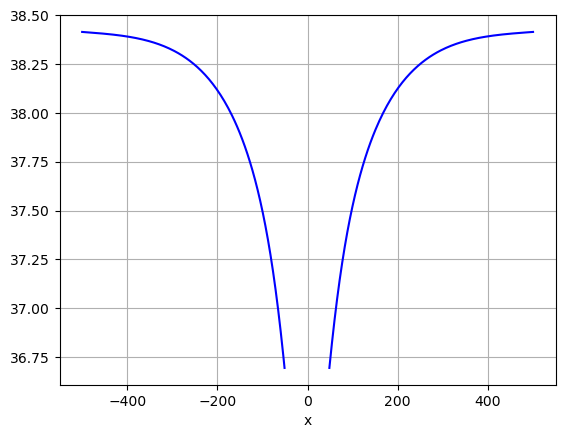

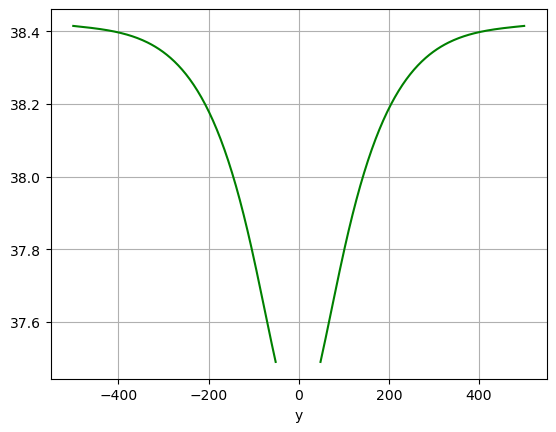

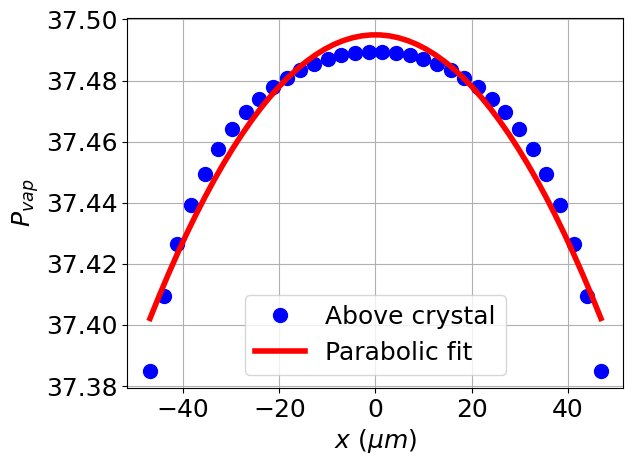

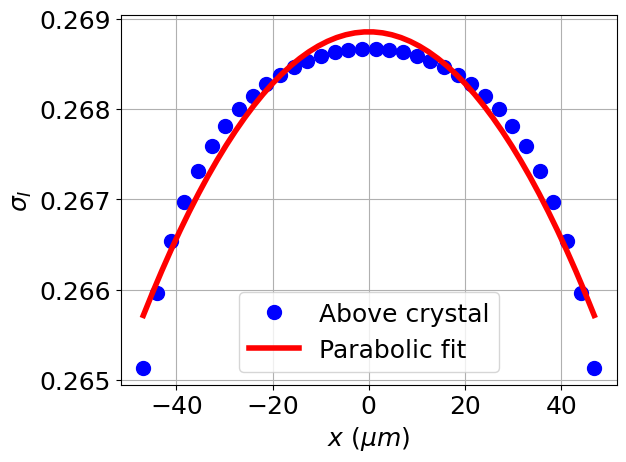

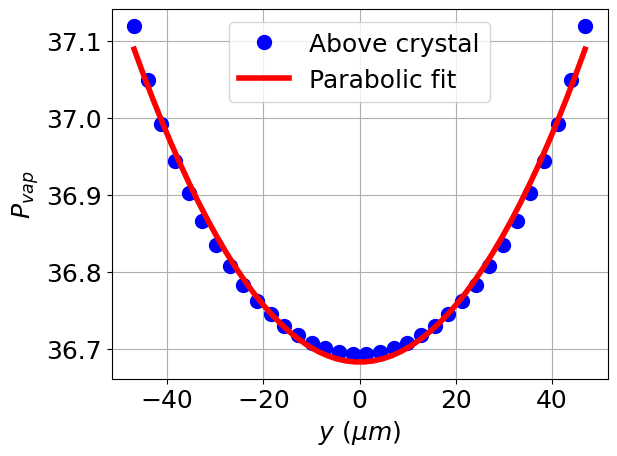

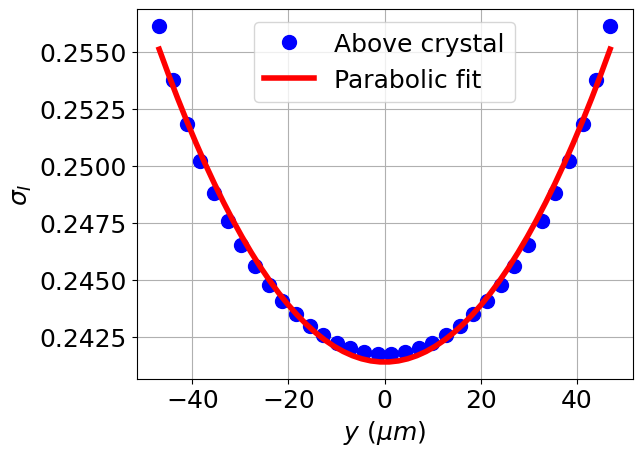

In [317]:
# Time reporting
print('dt, tmax = ',dt, dt*ntimes)

# We'll need this for relative supersaturations
P_vapor_eq = Clausius_Clapeyron(Temp,AssignQuantity)

# Reporting on the one of the distances
iwantthisone = -1
uslicex = np.squeeze(uslicex_list[iwantthisone])
uslicey = np.squeeze(uslicey_list[iwantthisone])

# Filling in where the crystal is
fillin(un,ixbox,iybox)

# Plotting from far afield up to the box
iextend = 10
iextend = 0
fontsize = 18
color = 'k'
linewidth = 4
markersize = 10
dpi = 300

ixbox_pre = slice(0,ixboxmin)
ixbox_post = slice(ixboxmax,nx)
plt.figure()
plt.plot(x[ixbox_pre], un[ixbox_pre,nymid], 'blue')
plt.plot(x[ixbox_post],un[ixbox_post,nymid],'blue')
plt.xlabel('x')
plt.grid(True)

iybox_pre = slice(0,iyboxmin)
iybox_post = slice(iyboxmax,ny)
plt.figure()
plt.plot(y[iybox_pre], un[nxmid,iybox_pre], 'green')
plt.plot(y[iybox_post],un[nxmid,iybox_post],'green')
plt.xlabel('y')
plt.grid(True)

# Pvap right above the surface in the x-direction
plt.figure()
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uslicex,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(xshifted.magnitude,uslicex.magnitude,2); #print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigixbox = [ix for ix in range(nxmid-boxradx-iextend,nxmid+boxradx+iextend)]
biguslice = un[bigixbox,nymid+boxrady]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
if iextend>0:
    plt.plot(bigxshifted,biguslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$P_{vap}$',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.savefig(figuretitle+'_Pvap_x',dpi=dpi,bbox_inches='tight')
print('in the x-direction, I get ', p)

# Sigma right above the surface in the x-direction
sigmaslicex = (uslicex-P_vapor_eq)/P_vapor_eq
plt.figure()
plt.plot(xshifted,sigmaslicex,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(xshifted.magnitude,sigmaslicex.magnitude,2); #print(p)
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigsigmaIslice = (un[bigixbox,nymid+boxrady]-P_vapor_eq.magnitude)/P_vapor_eq.magnitude
if iextend>0:
    plt.plot(bigxshifted,bigsigmaIslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$\sigma_I$',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.savefig(figuretitle+'_sigmaI_x',dpi=dpi,bbox_inches='tight')
print('in the x-direction, I get ', p)

# Pvap right above the surface in the y-direction
plt.figure()
yshifted = y[iybox]-y[nymid]+dy/2
plt.plot(yshifted,uslicey,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(yshifted.magnitude,uslicey.magnitude,2); #print(p)
yshifted_theory = np.linspace(min(yshifted),max(yshifted))
plt.plot(yshifted_theory,np.polyval(p,yshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigiybox = [iy for iy in range(nymid-boxrady-iextend,nymid+boxrady+iextend)]
biguslice = un[nxmid+boxradx,bigiybox]
bigyshifted = y[bigiybox]-y[nymid]+dy/2
if iextend>0:
    plt.plot(bigyshifted,biguslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$y$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$P_{vap}$',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.savefig(figuretitle+'_Pvap_y',dpi=dpi,bbox_inches='tight')
print('in the y-direction, I get ', p)

# Sigma right above the surface in the y-direction
P_vapor_eq = Clausius_Clapeyron(Temp,AssignQuantity)
sigmaslicey = (uslicey-P_vapor_eq)/P_vapor_eq
plt.figure()
plt.plot(yshifted,sigmaslicey,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(yshifted.magnitude,sigmaslicey.magnitude,2); #print(p)
plt.plot(yshifted_theory,np.polyval(p,yshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigsigmaIslice = (un[nxmid+boxradx,bigiybox]-P_vapor_eq.magnitude)/P_vapor_eq.magnitude
if iextend>0:
    plt.plot(bigxshifted,bigsigmaIslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$y$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$\sigma_I$',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.savefig(figuretitle+'_sigmaI_y',dpi=dpi,bbox_inches='tight')
print('in the y-direction, I get ', p)

# # Plotting the surface supersaturation at the corner of the crystal (x and y)
# plt.figure()
# sigmaDx = uslicex0_list/P_vapor_eq-1
# sigmaDy = uslicey0_list/P_vapor_eq-1
# plt.plot(Lx_list,sigmaDx,'-o')
# plt.plot(Ly_list,sigmaDy,'-x')
# plt.xlabel(r'$L_x$ or $L_y$ ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_I$ (corner)',fontsize=fontsize)
# plt.grid(True)

# # Plotting the surface supersaturation at the corner of the crystal (x only)
# plt.figure()
# plt.plot(Lx_list,sigmaDx,'-o')
# plt.xlabel(r'$L_x$ ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_I$ (corner)',fontsize=fontsize)
# print('L = ',Lx_list)
# print('sigmaIcorner(L) = ', sigmaDx)
# plt.grid(True)

# # Plotting the effective alpha at the corner of the crystal
# alphaIcorner = g_ice.magnitude/(sigmaDx.magnitude*nu_kin.magnitude)
# plt.figure()
# plt.plot(Lx_list,alphaIcorner,'-o')
# plt.xlabel(r'$L_x$ ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\alpha_I$ (corner)',fontsize=fontsize)
# print('L = ',Lx_list)
# print('α (I,corner) = ',alphaIcorner)
# plt.grid(True)

# # Graph as contour plot
# fig,ax = plt.subplots()
# CS = ax.contour(x.magnitude,y.magnitude,un.T)
# ax.set_xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
# ax.set_ylabel(r'$y$ ($\mu m$)', fontsize=fontsize)
# fig.colorbar(CS)
# xvec = (x[ixboxmin].magnitude,x[ixboxmin].magnitude)
# yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
# plt.plot(xvec,yvec,color=color,linewidth=linewidth)
# xvec = (x[ixboxmax].magnitude,x[ixboxmax].magnitude)
# yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
# plt.plot(xvec,yvec,color=color,linewidth=linewidth)
# xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
# yvec = (y[iyboxmin].magnitude,y[iyboxmin].magnitude)
# plt.plot(xvec,yvec,color=color,linewidth=linewidth)
# xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
# yvec = (y[iyboxmax].magnitude,y[iyboxmax].magnitude)
# plt.plot(xvec,yvec,color=color,linewidth=linewidth)

# # The center reduction
# plt.figure()
# plt.plot(Lx_list,c_rx_percent_list, 'o',label='x-direction')
# plt.plot(Ly_list,c_ry_percent_list, 'x',label='y-direction')
# plt.xlabel(r'$L_x$ or $L_x$ ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$c_r$ (%)', fontsize=fontsize)
# plt.legend()
# plt.grid(True)

# # The center reduction
# plt.figure()
# plt.plot(Lx_list,c_rx_percent_list, 'o',label='computed')
# plt.xlabel(r'$L_x$ ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$c_r$ (%)', fontsize=fontsize)
# plt.grid(True)
# if len(Lx_list) > 1:
#     print('For D = ', D)
#     px = np.polyfit(Lx_list.magnitude,c_rx_percent_list,1)
#     print('np.flip(px) =', np.flip(px))
#     print('if y = mx+b ...')
#     print('m = ',px[0])
#     print('b = ',px[1])
#     print('L_center_reduction = ', 1/px[0])
#     plt.plot(Lx_list,plt.polyval(px,Lx_list.magnitude),label='best-fit')
#     plt.legend()
print('cr (%) = ', c_rx_percent_list)

Contours range from  36.5 to  38.5
Contours range from  0.24 to  0.3


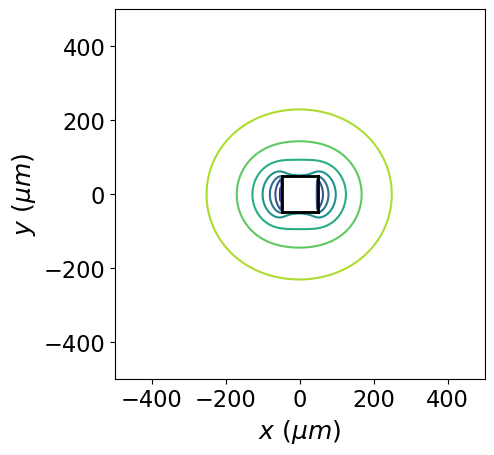

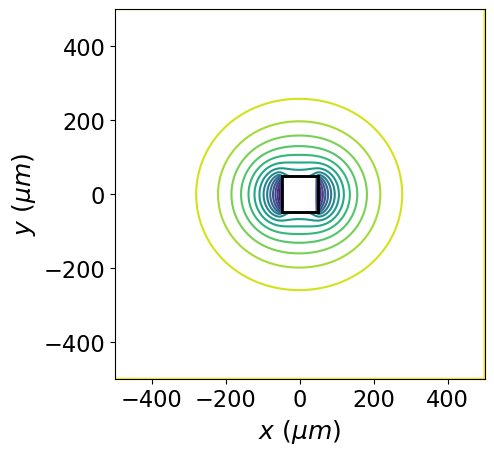

In [318]:
# Graph Pvap as contour plot
fig,ax = plt.subplots()
ax.set_aspect('equal')
boxlinewidth = 2
contour_dpi = 300
CS = ax.contour(x.magnitude,y.magnitude,un.T)
print('Contours range from ', CS.cvalues[0], 'to ', CS.cvalues[-1])
ax.set_xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
ax.set_ylabel(r'$y$ ($\mu m$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize*.9)
# fig.colorbar(CS)
print(CS)
xvec = (x[ixboxmin].magnitude,x[ixboxmin].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
xvec = (x[ixboxmax].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmin].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmax].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
plt.savefig(figuretitle+'_Pvap_contours',dpi=contour_dpi,bbox_inches='tight')

# Graph sigma as contour plot
fig,ax = plt.subplots()
ax.set_aspect('equal')
boxlinewidth = 2
contour_dpi = 300
sigmaI = (un-P_vapor_eq.magnitude)/P_vapor_eq.magnitude 
CS = ax.contour(x.magnitude,y.magnitude,sigmaI.T,levels=15)
print('Contours range from ', CS.cvalues[0], 'to ', CS.cvalues[-1])
ax.set_xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
ax.set_ylabel(r'$y$ ($\mu m$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize*.9)
# fig.colorbar(CS)
print(CS)
xvec = (x[ixboxmin].magnitude,x[ixboxmin].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
xvec = (x[ixboxmax].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmin].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmax].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=boxlinewidth)
plt.savefig(figuretitle+'_sigmaI_contours',dpi=contour_dpi,bbox_inches='tight')

### Doing this again to sort out the relaxation time after a perturbation
Assuming "un" has the last time step of the last L-value.

In [320]:
# # Times after perturbation
# ntimes_after_perturbation = ntimes
# tkeep = np.linspace(0,ntimes_after_perturbation*dt,ntimes_after_perturbation)

# # This is the perturbation factor
# pertfactor = 1.1

# # The unperturbed run
# un_unperturbed = cp(un)
# ukeep_unperturbed = []
# ukeepL_unperturbed = []

# for i in range(ntimes_after_perturbation):
#     ukeep_unperturbed.append(un_unperturbed[nxmid,nymid+boxrady])
#     ukeepL_unperturbed.append(un_unperturbed[ixbox,nymid+boxrady][0])
#     un_unperturbed = propagate(un_unperturbed,ixbox,iybox,udirichlet_mag,uneumannx_mag,uneumanny_mag,Dxeff,Dyeff)

# # The perturbed run
# un_perturbed = cp(un)
# un_perturbed[nxmid,nymid+boxrady] *= pertfactor
# wider = 5
# for iwider in range(1,wider):
#     un_perturbed[nxmid-iwider,nymid+boxrady] *= pertfactor
#     un_perturbed[nxmid+iwider,nymid+boxrady] *= pertfactor
# ukeep_perturbed = []
# un_perturbed_initial = cp(un_perturbed)
# ukeepL_perturbed = []
# for i in range(ntimes_after_perturbation):
#     ukeep_perturbed.append(un_perturbed[nxmid,nymid+boxrady])
#     ukeepL_perturbed.append(un_perturbed[ixbox,nymid+boxrady][0])
#     un_perturbed = propagate(un_perturbed,ixbox,iybox,udirichlet_mag,uneumannx_mag,uneumanny_mag,Dxeff,Dyeff)

In [321]:
# # Taking a look at the profile results
# uslice_unperturbed_final = un_unperturbed[ixbox,nymid+boxrady]
# uslice_perturbed_final = un_perturbed[ixbox,nymid+boxrady]
# uslice_perturbed_initial = un_perturbed_initial[ixbox,nymid+boxrady]
# plt.figure()
# plt.plot(xshifted,uslice_unperturbed_final,'s',label='unperturbed (final)')
# plt.plot(xshifted,uslice_perturbed_final,'x',label='perturbed (final)')
# plt.plot(xshifted,uslice_perturbed_initial,'o',label='perturbed (initial)')
# plt.grid(True)
# plt.legend()

# # Taking a look at pressures at the center over time
# ukeep_perturbed_nparray = np.array(ukeep_perturbed)
# ukeep_unperturbed_nparray = np.array(ukeep_unperturbed)
# deltaPressure = (ukeep_perturbed_nparray-ukeep_unperturbed_nparray)
# plt.figure()
# plt.plot(tkeep,deltaPressure)
# plt.xlabel('time (microseconds)')
# plt.grid(True)
# tau = tkeep[np.argmin(np.abs(deltaPressure/deltaPressure[0]-.5))]
# print('Approximate half-life =',tau)

# # Taking a look at center reductions over time
# ukeepL_perturbed_nparray = np.array(ukeepL_perturbed)
# ukeepL_unperturbed_nparray = np.array(ukeepL_unperturbed)
# c_rx_percent_perturbed = (ukeepL_perturbed_nparray-ukeep_perturbed_nparray)/ukeepL_perturbed_nparray*100
# c_rx_percent_unperturbed = (ukeepL_unperturbed_nparray-ukeep_unperturbed_nparray)/ukeepL_unperturbed_nparray*100
# plt.figure()
# plt.plot(tkeep,c_rx_percent_perturbed,label='perturbed')
# plt.plot(tkeep,c_rx_percent_unperturbed,label='unperturbed')
# plt.xlabel('time (microseconds)')
# plt.ylabel(r'$c_r$ (%)')
# plt.legend()
# plt.grid(True)

# # Taking a look at center reductions as a % of the unperturbed over time
# c_rx_percent_difference = (c_rx_percent_perturbed-c_rx_percent_unperturbed)/c_rx_percent_unperturbed*100
# plt.figure()
# plt.plot(tkeep,c_rx_percent_difference,label='difference')
# plt.xlabel('time (microseconds)')
# plt.grid(True)
# # plt.ylim([-10,10])
# tau = tkeep[np.argmin((c_rx_percent_difference+5)**2)]
# print('95% recovery time =',tau)

In [322]:
# ### Connecting to the continuum code ...
# nmpermonolayer = AssignQuantity(0.3,'nanometer')
# print('nmpermonolayer = ', nmpermonolayer)
# growthrate = g_ice
# print('growthrate = ', growthrate)
# growthrate = g_ice/nmpermonolayer; growthrate.ito('1/second')
# print('growthrate = ', growthrate)
# HLS = growthrate*Lx
# HLS.ito('micrometer/microsecond')
# print('HLS = ', HLS)
# print()

# # Guessing at lambda from SEM
# dz = AssignQuantity(1,'micrometer')
# dx = AssignQuantity(40,'micrometer')
# dzdx = dz/dx
# dlayersdx = dzdx/nmpermonolayer
# dlayersdx.ito('1/micrometer')
# lambdabar = 1/dlayersdx
# residence_time = lambdabar/HLS
# print('SEM:')
# print('    lambda = ', lambdabar)
# print('    Residence time SEM = ', residence_time)
# print()

# # CM
# lambdabar = AssignQuantity(3,'micrometer')
# residence_time = lambdabar/HLS
# print('CM:')
# print('    lambda = ', lambdabar)
# print('    residence_time = ', residence_time)